<a href="https://colab.research.google.com/github/jvaaguiar/Img2Mesh/blob/master/Img2Mesh_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [!] Preprocessing config (in / out)

In [0]:
from google.colab import drive
_ = drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
outroot = '/content/objnet/';
!mkdir {outroot}
tarsroot = '/content/drive/My Drive/Img2Mesh/dataset/tars/test_new_tars/'

mkdir: cannot create directory ‘/content/objnet/’: File exists


# Requirements

Download and install all softwares and libraries required by the notebook and the git code
* pyrender : python library for rendering
  * OS Mesa : off-screen rendering software
  * pyopengl : python library for openGL 
* Img2Mesh : project git with preprocessing tools for
  * rendering the 6 cameras (top, bottom, left, right, front, back)
  * conversion between .off and .obj 3d objects formats


In [0]:
# Install dependencies - OSMesa, mmatl's fork of PyOpenGL
_ = !sudo apt update
_ = !sudo wget https://github.com/mmatl/travis_debs/raw/master/xenial/mesa_18.3.3-0.deb
_ = !sudo dpkg -i ./mesa_18.3.3-0.deb || true
_ = !sudo apt install -f
_ = !git clone https://github.com/mmatl/pyopengl.git
_ = !pip install ./pyopengl

# Install pyrender
_ = !pip install pyrender

# Get git repo
_ = !git clone https://github.com/jvaaguiar/Img2Mesh.git

import sys
sys.path.append('/content/Img2Mesh')

In [0]:
# file conversions
from preprocessing.prereq import read_off, off2obj
# camera transformations
from preprocessing.prereq import topCamera, bottomCamera, frontCamera
from preprocessing.prereq import backCamera, rightCamera, leftCamera
# data normalization
from preprocessing.prereq import scaleVertices
# obj render from camera
from preprocessing.prereq import render

In [0]:
# remove warings from trimesh library
import warnings
warnings.filterwarnings("ignore")

# Get ModelNet Dataset

This dataset has a collection of 3d objects sorted by class.
It is thus used in <b>classification</b>

In order to use it for our <b>regression</b> we render their objects in order to build a dataset of {image} -> {3d object}

More info: https://modelnet.cs.princeton.edu/

In [0]:
path_modelnet = '\'/content/drive/Img2Mesh/dataset/modelnet40_manually_aligned.tar\''
inroot = '/content/modelnet'
!mkdir {inroot}
_ = !tar -xf {path_modelnet} -C '/content/modelnet'

# this version of modelnet was downloaded the 4 dec 2019
# the modelnet dataset can also be downloaded from its original source with:
# _ = !wget --no-check-certificate https://lmb.informatik.uni-freiburg.de/resources/datasets/ORION/modelnet40_manually_aligned.tar

In [0]:
folders = !ls -1 {inroot}
folders = folders[0:1]
print(folders)

In [0]:
import os
import glob

classes = []
for f in folders:
  test  = glob.glob(os.path.join(inroot + f, 'test/*.off'))
  train = glob.glob(os.path.join(inroot + f, 'train/*.off'))
  
  classes.append({'folder': f, 'train': train, 'test': test});

# Test Render

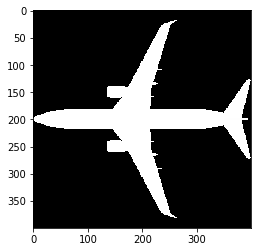

In [0]:
import matplotlib.pyplot as plt
off = classes[0]['train'][0];
obj = off.replace('.off', '.obj');
verts, faces = off2obj(off, obj);
top = render(obj, topCamera());
_ = plt.imshow(top, cmap='gray')

# Prepare Silhouette Dataset

In [0]:
# render cameras {top, bottom, front, back, right, left} of off objects
# infolder : folder of input offs
# outfolder : folder of input .npy files with
#             - 6 rendered images
#             - vertices positions
#             - faces list
def convertData (infolder, outfolder, offs):
  nbdata, prevnb = 0, 0
  print("%data: ", end='')

  for off in offs:
    nbdata = nbdata+1
    if (int(10*nbdata/len(offs)) > prevnb):
      prevnb = int(10*nbdata/len(offs))
      print(prevnb, end=', ')

    obj = off.replace('.off', '.obj');
    offpath = off;
    objpath = obj.replace(infolder, outfolder);
    
    verts, faces = off2obj(offpath, objpath);

    top, bottom = render(objpath, topCamera()), render(objpath, bottomCamera())
    front, back = render(objpath, frontCamera()), render(objpath, backCamera())
    right, left = render(objpath, rightCamera()), render(objpath, leftCamera())

    verts = scaleVertices(verts, feature_range=(0, 1))
    toSave = {'vertices': verts, 'faces': faces,
              'top': top, 'bottom': bottom,
              'front': front, 'back': back,
              'left': left, 'right': right}

    np.save(objpath.replace('.obj', '.npy'), toSave);

    !rm {offpath}
    !rm {objpath}
  !rm -r {infolder}
  print('')

In [0]:
# render all data from the the 
for category in classes:
  print('-> ' + category['folder']);

  incat = root + category['folder'];
  outcat = outroot + category['folder'];

  !mkdir {outcat}

  #test data
  print("#Test:")
  intest  = os.path.join(incat, 'test');
  outtest = os.path.join(outcat, 'test');

  !mkdir {outtest}

  convertData (intest, outtest, category['test']);

  #train data
  print("#Train:")
  intrain  = os.path.join(incat, 'train');
  outtrain = os.path.join(outcat, 'train');

  !mkdir {outtrain}

  convertData (intrain, outtrain, category['train']);

  !rm -r {incat}
  _ = !(cd {outcat + "/.."} && GZIP=-9 tar -czpvf {tarsroot + category['folder'] + ".tar.gz"} *)

-> airplane
#Test:
%data: 

KeyboardInterrupt: ignored